In [1]:
import os, sys
from motion_planner import MotionPlanner, Trajectory, RobotModel
import numpy as np, matplotlib.pyplot as plt

### Create your motion planner

In [2]:
planner = MotionPlanner(RobotModel.Panda) # Change to RobotModel.Kuka7 or RobotModel.Kuka14

### Set boundary conditions

In [11]:
# Initial and target state, for instance :
qlim =planner.robot_utils.X_limits
qdotlim = planner.robot_utils.V_limits
q0, dq0, ddq0 = planner.sample_state(N=1, set_qddot_to_zero=True)
qd, dqd, ddqd = planner.sample_state(N=1, set_qddot_to_zero=True)

# Set the initial and target state
planner.set_current_state((q0, dq0, ddq0))
planner.set_target_state((qd, dqd, ddqd))

### Solve and get trajectory

In [12]:
info = planner.solve(ruckig_as_warm_start=True, sqp_max_iter=2) # If you only want to solve the ruckig initial guess, use planner.solve(ruckig=True)
print(info)

{'status': 1, 'iter': 2, 'time_to_solve': 0.04625749588012695}


In [13]:
traj = planner.get_trajectory() # Return the polympc trajectory, if it already has been solved 
traj_ruckig = planner.get_trajectory(ruckig=True) # Return the ruckig trajectory

If you have several trajectories to compute, you can concatenate these by using the "+" operator :

In [14]:
print("Shape of traj is initially : {} ({} trajectory of {} time-steps)".format(traj.shape, *traj.shape))
traj += traj_ruckig
print("After using the + operator traj has now shape : {} ({} trajectories of {} time-steps each)".format(traj.shape, *traj.shape))

Shape of traj is initially : (1, 101) (1 trajectory of 101 time-steps)
After using the + operator traj has now shape : (2, 101) (2 trajectories of 101 time-steps each)


### Accessing t, q, qdot, qddot and tau
To access the results, you can use one of these notations:

In [7]:
t = traj["t"]
q = traj.q # If you want to access the q trajectories
qdot = traj["qdot"][0] # If you want to access the first qdot trajectory
t, q, qdot, qddot, tau = traj[1] # If you want to get all the state from the second trajectory at once

# 
# etc ..
#

print(t.shape, q.shape, qdot.shape, qddot.shape, tau.shape)

(101,) (101, 7) (101, 7) (101, 7) (101, 7)


### Trajectory analysis
The .get_trajectory() method returns a Trajectory object that provides several useful analysis methods. To check if the trajectories satisfy all the constraints: 

In [8]:
print("Constraint satisfied : {}".format(traj.all_cons_satisfied))

Constraint satisfied : [ True  True]


the .all_cons_satisfied attribute **returns one boolean per trajectory stored!** You can also assess each constraint separately by accessing the attributes :
- .q_cons_satisfied
- .qdot_cons_satisfied
- .qddot_cons_satisfied
- .tau_cons_satisfied

## Forward & Inverse Kinematics
You can switch between the joint space and task space trajectories using the .forward_kinematics(q) and .inverse_kinematics(pos, rot) method.

In [15]:
pos, rot = planner.forward_kinematics(traj.q) # Compute end-effector position from joint angles
q_from_ik = planner.inverse_kinematics(pos, rot) # Compute joint angles from end-effector position
pos_from_ik, rot_from_ik = planner.forward_kinematics(q_from_ik) # Compute back end-effector position from joint angles (sanity check)

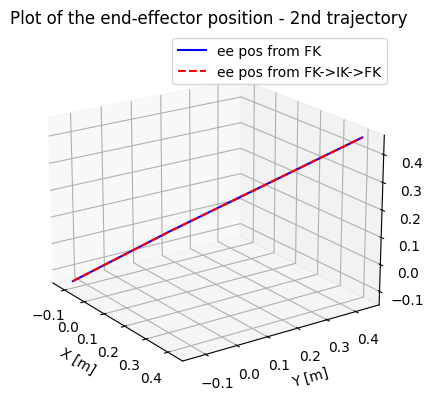

In [16]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(pos[1, 0], pos[1, 1], 'b', zs=pos[1, 2], label="ee pos from FK")
ax.plot(pos_from_ik[1, 0], pos_from_ik[1, 1], '--r', zs=pos_from_ik[1, 2], label="ee pos from FK->IK->FK")
ax.view_init(elev=20, azim=-35, roll=0)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title("Plot of the end-effector position - 2nd trajectory")
ax.legend()
plt.show()

### Compute Power
You can access the total power of a trajectory by using the property .power.

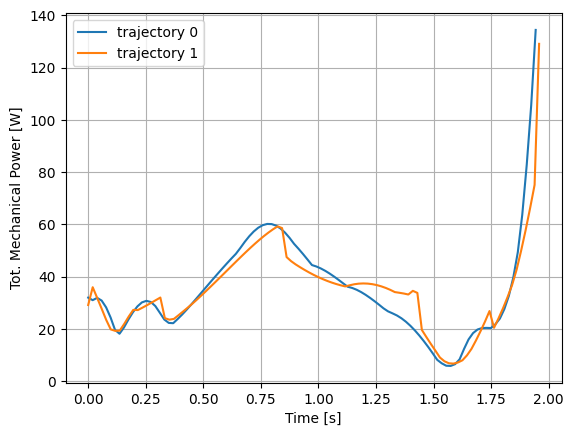

In [11]:
plt.figure()
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Tot. Mechanical Power [W]")
for i in range(len(traj)):
    plt.plot(traj.t[i], traj.power[i], label="trajectory {}".format(i))
plt.legend()

### Compute batch of trajectories
If you need to generate a batch of N trajectories, for training a model for instance, you can use something similar to:

In [3]:
N = 100
batch_of_traj = Trajectory(planner.robot_utils) # Create a Trajectory object to store multiple trajectories

# Sample N random initial and target states
q0, qdot0, qddot0 = planner.sample_state(N, set_qddot_to_zero=True)
qd, qdotd, qddotd = planner.sample_state(N, set_qddot_to_zero=True)

for i, (q0_i, qdot0_i, qddot0_i, qd_i, qdotd_i, qddotd_i) in enumerate(zip(q0, qdot0, qddot0, qd, qdotd, qddotd)):
    # Set the initial and target state
    planner.set_current_state((q0_i, qdot0_i, qddot0_i))
    planner.set_target_state((qd_i, qdotd_i, qddotd_i))

    # Solve the problem
    planner.solve(ruckig_as_warm_start=True, sqp_max_iter=2)
    
    # Get the trajectory and add it to the batch
    traj_i = planner.get_trajectory()
    batch_of_traj += traj_i

    # Print the progress
    sys.stdout.write("\rProgress : {}%".format(int(100*(i+1)/N)))

print("\nShape of batch_of_traj is : {} ({} trajectories of {} time-steps each)".format(batch_of_traj.shape, *batch_of_traj.shape))

Progress : 100%
Shape of batch_of_traj is : (100, 101) (100 trajectories of 101 time-steps each)


Or simply the built-in method :

In [14]:
# Sample N random initial and target states
start_state = planner.sample_state(40, set_qddot_to_zero=True)
target_state = planner.sample_state(40, set_qddot_to_zero=True)

# Solve the problem and return the batch of trajectories as well as a list of info dictionnaries
batch_of_traj, info = planner.solve_and_get_batch_of_traj(start_state, target_state, ruckig_as_warm_start=True, sqp_max_iter=2) # Solve and get N trajectories at once
print("Shape of batch_of_traj is : {} ({} trajectories of {} time-steps each)".format(batch_of_traj.shape, *batch_of_traj.shape))

Shape of batch_of_traj is : (40, 101) (40 trajectories of 101 time-steps each)
